# LangGraph and LangSmith - Agentic RAG Powered by LangChain

In the following notebook we'll complete the following tasks:

- 🤝 Breakout Room #1:
  1. Install required libraries
  2. Set Environment Variables
  3. Creating our Tool Belt
  4. Creating Our State
  5. Creating and Compiling A Graph!

- 🤝 Breakout Room #2:
  1. Evaluating the LangGraph Application with LangSmith
  2. Adding Helpfulness Check and "Loop" Limits
  3. LangGraph for the "Patterns" of GenAI

# 🤝 Breakout Room #1

## Part 1: LangGraph - Building Cyclic Applications with LangChain

LangGraph is a tool that leverages LangChain Expression Language to build coordinated multi-actor and stateful applications that includes cyclic behaviour.

### Why Cycles?

In essence, we can think of a cycle in our graph as a more robust and customizable loop. It allows us to keep our application agent-forward while still giving the powerful functionality of traditional loops.

Due to the inclusion of cycles over loops, we can also compose rather complex flows through our graph in a much more readable and natural fashion. Effectively allowing us to recreate application flowcharts in code in an almost 1-to-1 fashion.

### Why LangGraph?

Beyond the agent-forward approach - we can easily compose and combine traditional "DAG" (directed acyclic graph) chains with powerful cyclic behaviour due to the tight integration with LCEL. This means it's a natural extension to LangChain's core offerings!

## Task 1:  Dependencies


## Task 2: Environment Variables

We'll want to set our OpenAI, Tavily, and LangSmith API keys along with our LangSmith environment variables.

In [43]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

In [44]:
os.environ["TAVILY_API_KEY"] = getpass.getpass("TAVILY_API_KEY")

In [45]:
from uuid import uuid4

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE8 - LangGraph - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key: ")

## Task 3: Creating our Tool Belt

As is usually the case, we'll want to equip our agent with a toolbelt to help answer questions and add external knowledge.

There's a tonne of tools in the [LangChain Community Repo](https://github.com/langchain-ai/langchain-community/tree/main/libs/community) but we'll stick to a couple just so we can observe the cyclic nature of LangGraph in action!

We'll leverage:

- [Tavily Search Results](https://github.com/langchain-ai/langchain-community/blob/main/libs/community/langchain_community/tools/tavily_search/tool.py)
- [Arxiv](https://github.com/langchain-ai/langchain-community/blob/main/libs/community/langchain_community/tools/arxiv/tool.py)

#### 🏗️ Activity #1:

Please add the tools to use into our toolbelt.

> NOTE: Each tool in our toolbelt should be a method.

In [46]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools.arxiv.tool import ArxivQueryRun

tavily_tool = TavilySearchResults(max_results=5)

tool_belt = [
    tavily_tool,
    ArxivQueryRun(),
]

### Model

Now we can set-up our model! We'll leverage the familiar OpenAI model suite for this example - but it's not *necessary* to use with LangGraph. LangGraph supports all models - though you might not find success with smaller models - as such, they recommend you stick with:

- OpenAI's GPT-3.5 and GPT-4
- Anthropic's Claude
- Google's Gemini

> NOTE: Because we're leveraging the OpenAI function calling API - we'll need to use OpenAI *for this specific example* (or any other service that exposes an OpenAI-style function calling API.

In [47]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4.1-nano", temperature=0)

Now that we have our model set-up, let's "put on the tool belt", which is to say: We'll bind our LangChain formatted tools to the model in an OpenAI function calling format.

In [48]:
model = model.bind_tools(tool_belt)

#### ❓ Question #1:

How does the model determine which tool to use?

##### ✅ Answer:

The model uses a list of JSON Schemas that essentialy describes each tool's functionality (including its parameters and outputs). This list of tools is passed to the LLM alongside the user message. Based on this input the LLM then decides if it need to call any of the tools and responds back to the caller (eg. the application) telling which tool(s) needs to be called (executed).
LangGraph offers various tools redy to use and abstracts this Tool JSON Schema definition by binding a list of tools to the LLM in use.    

## Task 4: Putting the State in Stateful

Earlier we used this phrasing:

`coordinated multi-actor and stateful applications`

So what does that "stateful" mean?

To put it simply - we want to have **some kind of object which we can pass around our application that holds information about what the current situation** (state) is. Since our system will be constructed of many parts moving in a coordinated fashion - we want to be able to ensure we have some commonly understood idea of that state.

**LangGraph leverages a `StatefulGraph` which uses an `AgentState` object to pass information between the various nodes of the graph.**

There are more options than what we'll see below - but this `AgentState` object is one that is stored in a `TypedDict` with the key `messages` and the value is a `Sequence` of `BaseMessages` that will be appended to whenever the state changes.

Let's think about a simple example to help understand exactly what this means (we'll simplify a great deal to try and clearly communicate what state is doing):

1. We initialize our state object:
  - `{"messages" : []}`
2. Our user submits a query to our application.
  - New State: `HumanMessage(#1)`
  - `{"messages" : [HumanMessage(#1)}`
3. We pass our state object to an Agent node which is able to read the current state. It will use the last `HumanMessage` as input. It gets some kind of output which it will add to the state.
  - New State: `AgentMessage(#1, additional_kwargs {"function_call" : "WebSearchTool"})`
  - `{"messages" : [HumanMessage(#1), AgentMessage(#1, ...)]}`
4. We pass our state object to a "conditional node" (more on this later) which reads the last state to determine if we need to use a tool - which it can determine properly because of our provided object!

In [49]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
import operator
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
  messages: Annotated[list, add_messages]

## Task 5: It's Graphing Time!

**Now that we have state, and we have tools, and we have an LLM - we can finally start making our graph!**

Let's take a second to refresh ourselves about what a graph is in this context.

Graphs, also called networks in some circles, are a collection of connected objects.

The objects in question are typically called nodes, or vertices, and the connections are called edges.

Let's look at a simple graph.

![image](https://i.imgur.com/2NFLnIc.png)

Here, we're using the coloured circles to represent the nodes and the yellow lines to represent the edges. In this case, we're looking at a fully connected graph - where each node is connected by an edge to each other node.

If we were to **think about nodes** in the context of LangGraph - we would **think of a function, or an LCEL runnable**.

**If we were to think about edges** in the context of LangGraph - we might think of them as "paths to take" or **"where to pass our state object next"**.

Let's create some nodes and expand on our diagram.

> NOTE: Due to the tight integration with LCEL - we can comfortably create our nodes in an async fashion!

In [50]:
from langgraph.prebuilt import ToolNode

def call_model(state):
  messages = state["messages"]
  response = model.invoke(messages)
  return {"messages" : [response]}

tool_node = ToolNode(tool_belt)

Now we have two total nodes. We have:

- `call_model` is a node that will...well...call the model
- `tool_node` is a node which can call a tool

Let's start adding nodes! We'll update our diagram along the way to keep track of what this looks like!


In [51]:
from langgraph.graph import StateGraph, END

uncompiled_graph = StateGraph(AgentState)

uncompiled_graph.add_node("agent", call_model)
uncompiled_graph.add_node("action", tool_node)

Let's look at what we have so far:

![image](https://i.imgur.com/md7inqG.png)

Next, we'll add our entrypoint. All our entrypoint does is indicate which node is called first.

In [52]:
uncompiled_graph.set_entry_point("agent")

![image](https://i.imgur.com/wNixpJe.png)

Now we want to build a "conditional edge" which will use the output state of a node to determine which path to follow.

We can help conceptualize this by **thinking of our conditional edge as a conditional in a flowchart!**

Notice how our function simply checks if there is a "function_call" kwarg present.

Then we create an edge where the origin node is our agent node and our destination node is *either* the action node or the END (finish the graph).

It's important to highlight that the dictionary passed in as the third parameter (the mapping) should be created with the possible outputs of our conditional function in mind. In this case `should_continue` outputs either `"end"` or `"continue"` which are subsequently mapped to the action node or the END node.

In [53]:
def should_continue(state):
  last_message = state["messages"][-1]

  if last_message.tool_calls:
    return "action"

  return END

uncompiled_graph.add_conditional_edges(
    "agent",
    should_continue
)

Let's visualize what this looks like.

![image](https://i.imgur.com/8ZNwKI5.png)

Finally, we can add our last edge which will connect our action node to our agent node. This is because we *always* want our action node (which is used to call our tools) to return its output to our agent!

In [54]:
uncompiled_graph.add_edge("action", "agent")

Let's look at the final visualization.

![image](https://i.imgur.com/NWO7usO.png)

All that's left to do now is to compile our workflow - and we're off!

In [55]:
simple_agent_graph = uncompiled_graph.compile()

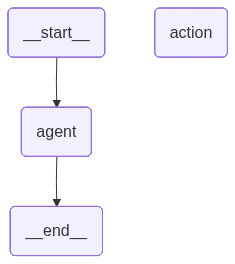

In [60]:
#graph visualization    

simple_agent_graph #.get_graph().print_ascii()

#### ❓ Question #2:

Is there any specific limit to how many times we can cycle?

##### ✅ Answer:
According to the documentation, by default, LangGraph has a recursion limit of 25 steps. This means your graph can execute a maximum of 25 super-steps during a single run. If your graph reaches this limit without meeting a stop condition, LangGraph will raise a GraphRecursionError. This typically indicates an infinite loop or cycles that don't have proper termination conditions.

You can control/change this default by setting the `recursion_limit` param while invoking the graph 

```
graph.invoke(inputs, config={"recursion_limit": 100})
```

If not, how could we impose a limit to the number of cycles?

##### ✅ Answer:
You can apply the following approaches to impose limits, like:
 * Counting messages: Since each cycle adds messages to the state, you can count them
 * Setting a threshold: Define a maximum number of iterations (like 10 in your example)
 * Forcing termination: Return "END" when the limit is reached

## Using Our Graph

Now that we've created and compiled our graph - we can call it *just as we'd call any other* `Runnable`!

Let's try out a few examples to see how it fairs:

In [57]:
from langchain_core.messages import HumanMessage

# Agent initial State
inputs = {"messages" : [HumanMessage(content="How are technical professionals using AI to improve their work?")]}

async for chunk in simple_agent_graph.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values["messages"])
        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='Technical professionals are using AI in various ways to enhance their work, including automating repetitive tasks, improving decision-making, analyzing large datasets, developing new products and services, and optimizing processes. They leverage AI for tasks such as machine learning model development, natural language processing, computer vision, predictive analytics, and automation. This integration helps increase efficiency, accuracy, and innovation across different industries. Would you like specific examples from particular fields or recent trends?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 89, 'prompt_tokens': 163, 'total_tokens': 252, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-1

Let's look at what happened:

##### ✅ Answer:

1. Our state object was populated with our request (*"How are technical professionals using AI to improve their work?"*)
2. The state object was passed into our **entry point** (agent node);
3. The agent node added an `AIMessage` containing its response to the state object and passed it over to the **conditional edge**;
6. The conditional edge inspected the state object, could not find the **"tool_calls"** in the `additional_kwarg` param and passed the state over to the **END node** finishing the graph execution!

##### LangSmith trace for this first run

![](./langsmith-trace-no-tools-call.png)

Now let's look at an example that shows a multiple tool usage - all with the same flow!

In [58]:
inputs = {"messages" : [HumanMessage(content="Search Arxiv for the A Comprehensive Survey of Deep Research paper, then search each of the authors to find out where they work now using Tavily!")]}

async for chunk in simple_agent_graph.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        if node == "action":
          print(f"Tool Used: {values['messages'][0].name}")
        print(values["messages"])

        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KLoE3VnGmhxHpoDgdEIpGV7n', 'function': {'arguments': '{"query": "A Comprehensive Survey of Deep Research"}', 'name': 'arxiv'}, 'type': 'function'}, {'id': 'call_GnDBengAdTKIs8GKSPJtY7OQ', 'function': {'arguments': '{"query": "author of A Comprehensive Survey of Deep Research"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 60, 'prompt_tokens': 182, 'total_tokens': 242, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_7c233bf9d1', 'id': 'chatcmpl-CK4H6MJAwbIxsHU6oNcR5IdDkB94Y', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--5b7d02f4-7f8

##### Langsmith trace with tools call

![](./langsmith-trace-with-tools-call.png)

#### 🏗️ Activity #2:

Please write out the steps the agent took to arrive at the correct answer.

##### ✅ Answer:

1. The Agent received our input message (`HumanMessage`) - *"Search Arxiv for the A Comprehensive Survey of Deep Research paper, ..."*
2. The Agent then passed the input message to the Model
3. The Model responded (`AIMesage`) with a list of tools (*Arxivix* and *Tavily Search*)
4. The Agent passed the message to the **Conditional Edge** (`should_continue`), which checked for the `tool_calls` key and decided to go to the Action node
5. The Action node then called the tools in order: 1st the Arxivix; 2nd the Tavily Search
6. The agent passed te tools'output to the Model, which in turn responded witht he final answer.
7. The final response was passed on to the Conditional Edge (`should_continue`), which checked for the `tool_calls` key and decided to END the flow.

# 🤝 Breakout Room #2

## Part 1: LangSmith Evaluator

### Pre-processing for LangSmith

To do a little bit more preprocessing, let's wrap our LangGraph agent in a simple chain.

In [59]:
def convert_inputs(input_object):
  return {"messages" : [HumanMessage(content=input_object["text"])]}

def parse_output(input_state):
  return {"answer" : input_state["messages"][-1].content}

agent_chain_with_formatting = convert_inputs | simple_agent_graph | parse_output

agent_chain_with_formatting.invoke({"text" : "What is Deep Research?"})

{'answer': 'Deep Research typically refers to an in-depth and comprehensive investigation or analysis into a specific subject or field. It involves thorough data collection, critical evaluation, and detailed examination to uncover insights, understand complex issues, or develop new knowledge. Deep Research is often used in academic, scientific, technological, and business contexts to inform decision-making, innovation, and strategic planning. \n\nIf you are referring to a specific organization, product, or platform named "Deep Research," please provide more context so I can give a more precise answer.'}

### Task 1: Creating An Evaluation Dataset

Just as we saw last week, we'll want to create a dataset to test our Agent's ability to answer questions.

In order to do this - we'll want to provide some questions and some answers. Let's look at how we can create such a dataset below.

```python
questions = [
    {
        "inputs" : {"text" : "Who were the main authors on the 'A Comprehensive Survey of Deep Research: Systems, Methodologies, and Applications' paper?"},
        "outputs" : {"must_mention" : ["Peng", "Xu"]}   
    },
    ...,
    {
        "inputs" : {"text" : "Where do the authors of the 'A Comprehensive Survey of Deep Research: Systems, Methodologies, and Applications' work now?"},
        "outputs" : {"must_mention" : ["Zhejiang", "Liberty Mutual"]}
    }
]
```

#### 🏗️ Activity #3:

Please create a dataset in the above format with at least 5 questions that pertain to the cohort use-case (more information [here](https://www.notion.so/Session-4-RAG-with-LangGraph-OSS-Local-Models-Eval-w-LangSmith-26acd547af3d80838d5beba464d7e701#26acd547af3d81d08809c9c82a462bdd)), or the use-case you're hoping to tackle in your Demo Day project.

In [62]:
questions = [
    {
        "inputs" : {"text" : "Search Arxiv for How people use ChatGPT Research paper, then search the web to find out how people use ChatGPT in their daily work using Tavily!"},
        "outputs" : {"must_mention" : ["emails", "reports", "spreadsheets", "documents", "presentations"]}
    },
    {
        "inputs" : {"text" : "What are the most common ways people use AI in their work?"},
        "outputs" : {"must_mention" : ["emails", "reports", "spreadsheets", "documents", "presentations"]}
    },
    {
        "inputs" : {"text" : "Do people use AI for their personal lives?"},
        "outputs" : {"must_mention" : ["productivity", "creativity", "learning", "health", "fitness"]}
    },
    {
        "inputs" : {"text" : "What concerns or challenges do people have when using AI?"},
        "outputs" : {"must_mention" : ["Privacy", "biases", "security", "trust", "governance"]}
    },
    {
        "inputs" : {"text" : "I'm an AI Engineer focusing on building intelligent agentic systems. Currently, I'm involved in a local Christian Church located in North Texas, USA. I'm also always looking to help my kids (currently Elementary and Middle Schoolers) get more engaged with their learning. What should I build to add value to the local communities I’m engaged in?"},
        "outputs" : {"must_mention" : ["Core Features", "MVP", "AI Agent", "LLM", "Problem it Solves", "Value Proposition"]}
    },
    {
        "inputs" : {"text" : "What AI powered Solutions are available for Legacy Application Modernizaton and Migration?"},
        "outputs" : {"must_mention" : ["business logic", "technology stack", "dependencies", "analysis"]}
    }
]

Now we can add our dataset to our LangSmith project using the following code which we saw last Thursday!

In [73]:
from langsmith import Client

client = Client()

dataset_name = f"Simple Search Agent - Evaluation Dataset - {uuid4().hex[0:8]}"

dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="Questions about the cohort use-case to evaluate the Simple Search Agent."
)

client.create_examples(
    dataset_id=dataset.id,
    examples=questions
)

{'example_ids': ['4a136c30-f852-47f9-8fd2-aa2d53278af6',
  '32460a59-89c8-4ee4-a18a-2ea8c37c8cbc',
  'fbafd7bf-ba62-4e5c-b5d7-1628229a670f',
  'a0b5c308-8f9a-4ae1-a28f-5c2f0e302d5c',
  'de4691ed-c067-4980-adad-6476c3ebf960',
  '9e3888ad-d681-49b9-ba74-cc65bbf8ac43'],
 'count': 6}

### Task 2: Adding Evaluators

Let's use the OpenEvals library to product an evaluator that we can then pass into LangSmith!

> NOTE: Examine the `CORRECTNESS_PROMPT` below!

In [64]:
from openevals.prompts import CORRECTNESS_PROMPT
print(CORRECTNESS_PROMPT)

You are an expert data labeler evaluating model outputs for correctness. Your task is to assign a score based on the following rubric:

<Rubric>
  A correct answer:
  - Provides accurate and complete information
  - Contains no factual errors
  - Addresses all parts of the question
  - Is logically consistent
  - Uses precise and accurate terminology

  When scoring, you should penalize:
  - Factual errors or inaccuracies
  - Incomplete or partial answers
  - Misleading or ambiguous statements
  - Incorrect terminology
  - Logical inconsistencies
  - Missing key information
</Rubric>

<Instructions>
  - Carefully read the input and output
  - Check for factual accuracy and completeness
  - Focus on correctness of information rather than style or verbosity
</Instructions>

<Reminder>
  The goal is to evaluate factual correctness and completeness of the response.
</Reminder>

<input>
{inputs}
</input>

<output>
{outputs}
</output>

Use the reference outputs below to help you evaluate the

In [65]:
from openevals.llm import create_llm_as_judge

correctness_evaluator = create_llm_as_judge(
        prompt=CORRECTNESS_PROMPT,
        model="openai:o3-mini", # very impactful to the final score
        feedback_key="correctness",
    )

Let's also create a custom Evaluator for our created dataset above - we do this by first making a simple Python function!

In [66]:
def must_mention(inputs: dict, outputs: dict, reference_outputs: dict) -> float:
  # determine if the phrases in the reference_outputs are in the outputs
  required = reference_outputs.get("must_mention") or []
  score = all(phrase in outputs["answer"] for phrase in required)
  return score

#### ❓ Question #4:

What are some ways you could improve this metric as-is?

> NOTE: Alternatively you can suggest where gaps exist in this method.

##### ✅ Answer:
###### Ways to Improve This Metric
The current metric logic implementation is a simple **binary evaluation** metric. Here a re some ways to improve it:

 * **Add Partial Credit Scoring**: the current metric is binary (0 or 1), but you could provide partial credit.
 
 * **Add Fuzzy Matching**: use fuzzy string matching to handle variations, typos, and synonyms.
 
 * **Add Semantic Similarity**: use embeddings to check for semantic similarity rather than exact string matching.
 
 * **Add Context Awareness**: consider the context around the mentions.

###### Gaps in the Current Method
1. **No Handling of Synonyms or Variations**
  * "emails" vs "email" vs "electronic mail"
  * "AI" vs "artificial intelligence"
  * Case sensitivity issues
2. **Binary Scoring is Too Rigid**
  * All-or-nothing approach doesn't reflect partial correctness
  * Doesn't account for quality of mentions
3. **No Context Consideration**
  * Doesn't distinguish between positive and negative mentions
  * Ignores the semantic meaning around the mention
4. **Limited to Exact String Matching**
  * Misses paraphrases or rephrased concepts
  * No semantic understanding
5. **No Confidence Scoring**
  * Doesn't provide insight into how confident the metric is
  * No explanation for why something scored low
6. **No Weighted Importance**
  * All required mentions treated equally
  * Some concepts might be more important than others

Task 3: Evaluating

All that is left to do is evaluate our agent's response!

In [67]:
results = client.evaluate(
    agent_chain_with_formatting,
    data=dataset.name,
    evaluators=[correctness_evaluator, must_mention],
    experiment_prefix="simple_agent, baseline",  # optional, experiment name prefix
    description="Testing the baseline system.",  # optional, experiment description
    max_concurrency=4, # optional, add concurrency
)

View the evaluation results for experiment: 'simple_agent, baseline-320802a6' at:
https://smith.langchain.com/o/bb9a3dd7-ec88-4998-a3cb-7a19da336bd6/datasets/3fb042a1-78c8-4b00-b143-66bad3d5fad3/compare?selectedSessions=5170b6f7-abf4-4f88-9cf8-ef26809bb573




0it [00:00, ?it/s]

**Eval results before metric improvements**

![Eval results](./langsmith-dataset-eval-1.png)

##### Improve the eval metric function

In [74]:
from difflib import SequenceMatcher
import numpy as np
from typing import List
from openai import OpenAI

def must_mention_improved(inputs: dict, outputs: dict, reference_outputs: dict) -> float:
    required = reference_outputs.get("must_mention") or []
    if not required:
        return 1.0
    
    answer = outputs["answer"].lower()
    matches = sum(1 for phrase in required if phrase.lower() in answer)
    return matches / len(required)  # Returns 0.0 to 1.0

def must_mention_fuzzy(inputs: dict, outputs: dict, reference_outputs: dict) -> float:
    required = reference_outputs.get("must_mention") or []
    answer = outputs["answer"].lower()
    
    total_score = 0
    for phrase in required:
        phrase_lower = phrase.lower()
        best_match = 0
        
        # Check exact match first
        if phrase_lower in answer:
            best_match = 1.0
        else:
            # Try fuzzy matching on word boundaries
            words = answer.split()
            for i in range(len(words) - len(phrase_lower.split()) + 1):
                candidate = " ".join(words[i:i+len(phrase_lower.split())])
                similarity = SequenceMatcher(None, phrase_lower, candidate).ratio()
                best_match = max(best_match, similarity)
        
        total_score += best_match
    
    return total_score / len(required) if required else 1.0

llm_client = OpenAI()
def get_embedding(text: str) -> List[float]:

    embedding = llm_client.embeddings.create(
        input=text, model="text-embedding-3-small"
    )

    return embedding.data[0].embedding

def must_mention_semantic(inputs: dict, outputs: dict, reference_outputs: dict) -> float:
    required = reference_outputs.get("must_mention") or []
    answer = outputs["answer"]
    
    if not required:
        return 1.0
    
    # Get embeddings for required phrases and answer
    required_embeddings = model.encode(required)
    answer_embedding = model.encode([answer])
    
    # Calculate cosine similarity
    similarities = np.dot(required_embeddings, answer_embedding.T).flatten()
    
    # Use threshold for semantic matching (e.g., 0.7)
    matches = np.sum(similarities > 0.7)
    return matches / len(required)


def must_mention_contextual(inputs: dict, outputs: dict, reference_outputs: dict) -> float:
    required = reference_outputs.get("must_mention") or []
    answer = outputs["answer"].lower()
    
    if not required:
        return 1.0
    
    total_score = 0
    for phrase in required:
        phrase_lower = phrase.lower()
        if phrase_lower in answer:
            # Find context around the mention
            phrase_index = answer.find(phrase_lower)
            context_start = max(0, phrase_index - 50)
            context_end = min(len(answer), phrase_index + len(phrase_lower) + 50)
            context = answer[context_start:context_end]
            
            # Check if context suggests positive mention (vs negative)
            positive_words = ["good", "effective", "useful", "important", "valuable"]
            negative_words = ["bad", "ineffective", "useless", "unimportant", "problematic"]
            
            context_score = 1.0
            if any(word in context for word in negative_words):
                context_score = 0.5
            elif any(word in context for word in positive_words):
                context_score = 1.2
            
            total_score += min(context_score, 1.0)
        else:
            total_score += 0
    
    return total_score / len(required)


def comprehensive_mention_evaluator(inputs: dict, outputs: dict, reference_outputs: dict) -> dict:
    required = reference_outputs.get("must_mention") or []
    
    return {
        "exact_match": must_mention(inputs, outputs, reference_outputs),
        "partial_credit": must_mention_improved(inputs, outputs, reference_outputs),
        "fuzzy_match": must_mention_fuzzy(inputs, outputs, reference_outputs),
        "semantic_similarity": must_mention_semantic(inputs, outputs, reference_outputs),
        "contextual": must_mention_contextual(inputs, outputs, reference_outputs)
    }

##### Reevaluate with new metric score functions

In [75]:
# Then use them in your evaluation
results = client.evaluate(
    agent_chain_with_formatting,
    data=dataset.name,
    evaluators=[
        correctness_evaluator,
        must_mention_improved,
        must_mention_fuzzy, 
        must_mention_contextual
    ],
    experiment_prefix="multi_metric_evaluation",
    description="Testing with multiple evaluation metrics",
    max_concurrency=4,
)

View the evaluation results for experiment: 'multi_metric_evaluation-0f2999dc' at:
https://smith.langchain.com/o/bb9a3dd7-ec88-4998-a3cb-7a19da336bd6/datasets/c7dfcd2c-50ea-4c77-a69b-f5a3b331559c/compare?selectedSessions=798f1066-78c6-4f6c-8ad8-89b3880fe126




0it [00:00, ?it/s]

**Eval results after metric improvements**

![Eval results](./langsmith-dataset-eval-multiple-score-metric-func.png)

As we can see in the above results (*from LangSmith Datasets & Experiments dashboard*), the `must_mention_fuzzy` score metric seems to be a better way to evaluate the output in our scenario.

## Part 2: LangGraph with Helpfulness:

### Task 3: Adding Helpfulness Check and "Loop" Limits

Now that we've done evaluation - **let's see if we can add an extra step where we review the content we've generated to confirm if it fully answers the user's query!**

We're going to make a few key adjustments to account for this:

1. We're going to add an artificial limit on how many "loops" the agent can go through - this will help us to avoid the potential situation where we never exit the loop.
2. We'll add to our existing conditional edge to obtain the behaviour we desire.

First, let's define our state again - we can check the length of the state object, so we don't need additional state for this.

In [76]:
class AgentState(TypedDict):
  # The add_messages reducer function defines how new messages should be added to this list.
  # It concatenates the new messages to the existing messages list, maintaining the chronological order
  messages: Annotated[list, add_messages]

Now we can set our graph up! This process will be almost entirely the same - with the inclusion of one additional node/conditional edge!

#### 🏗️ Activity #4:

Please write markdown for the following cells to explain what each is doing.

##### ✅ Answer:

Lets define a new Graph by adding our existing Nodes:
 * `call_model` responsible for calling the LLM and;
 * `tool_node` responsible to executing out tools (according to the LLM response tools parameter)

In [91]:
graph_with_helpfulness_check = StateGraph(AgentState)

graph_with_helpfulness_check.add_node("agent", call_model)
graph_with_helpfulness_check.add_node("action", tool_node)

Lets set the `agent` node (`call_model`) as the **entrypoint** for our graph.

In [92]:
graph_with_helpfulness_check.set_entry_point("agent")

Next we define our **conditional logic** which will be used as a *conditional edge* withing our graph. The logic builds a simple chain that:
 1. builds a prompt to determine the helpfulness of the LLM response using the 'initial query' and the 'final LLM response' as inputs;
 2. builds a 'helpfulness check chain' that pass the helpfulness prompt to the check model and;
 3. invoke the helpfulness check chain;
 4. based on the check result, it determines if the flow should *end* or *continue*.

In [93]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

def tool_call_or_helpful(state):
  last_message = state["messages"][-1]

  if last_message.tool_calls:
    return "action"

  initial_query = state["messages"][0]
  final_response = state["messages"][-1]

  if len(state["messages"]) > 10:
    return "END"

  prompt_template = """\
  Given an initial query and a final response, determine if the final response is extremely helpful or not. 
  Consider if the final response is conclusive or if it is a partial answer or if it suggests that can have different meanings depending on the context or if it need more context. 
  If is not conclusive, then it is not helpful in this context.
  Please indicate helpfulness with a 'Y' and unhelpfulness as an 'N'.

  Initial Query:
  {initial_query}

  Final Response:
  {final_response}"""

  helpfullness_prompt_template = PromptTemplate.from_template(prompt_template)

  helpfulness_check_model = ChatOpenAI(model="gpt-4.1-mini")

  helpfulness_chain = helpfullness_prompt_template | helpfulness_check_model | StrOutputParser()

  helpfulness_response = helpfulness_chain.invoke({"initial_query" : initial_query.content, "final_response" : final_response.content})

  if "Y" in helpfulness_response:
    return "end"
  else:
    return "continue"

Add the helpfullness conditional logic to the graph.

In [94]:
graph_with_helpfulness_check.add_conditional_edges(
    "agent",
    tool_call_or_helpful,
    {
        "continue" : "agent",
        "action" : "action",
        "end" : END
    }
)

Connect the `action` back to `agent` node.

In [95]:
graph_with_helpfulness_check.add_edge("action", "agent")

Compile out graph

In [96]:
agent_with_helpfulness_check = graph_with_helpfulness_check.compile()

Let's see how our graph looks like!

![](./helpfulness-check-graph3.png)

Give it a spin.

In [84]:
inputs = {"messages" : [HumanMessage(content="What are Deep Research Agents?")]}

async for chunk in agent_with_helpfulness_check.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values["messages"])
        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='Deep Research Agents are advanced AI systems designed to assist with in-depth research tasks. They leverage deep learning techniques and large datasets to analyze complex information, generate insights, and support decision-making across various fields such as science, technology, medicine, and more. These agents can automate literature reviews, extract relevant data from vast sources, and provide comprehensive summaries, making research more efficient and thorough. Would you like me to find more detailed or specific information about Deep Research Agents?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 93, 'prompt_tokens': 158, 'total_tokens': 251, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-

##### Langsmith trace

The trace bellow show the first graph exectution. Notice the helpfulness check output (`Y`), which proves the LLM response is considered Helpful given our user Query (***"What are Deep Research Agents?"***)

![](./langsmith-helpfulness-agent-trace.png)

#### Forcing a nonsesical prompt

In [97]:
inputs = {"messages" : [HumanMessage(content="What is the meaning of ev")]}

async for chunk in agent_with_helpfulness_check.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values["messages"])
        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='"EV" can have different meanings depending on the context. Could you please specify the context in which you encountered "EV"? For example, it could refer to "Electric Vehicle," "Expected Value" in statistics, "Enterprise Value" in finance, or something else.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 158, 'total_tokens': 213, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_7c233bf9d1', 'id': 'chatcmpl-CKvNmWCYLYTEC8SB7U8o5Zgf9DEFO', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--82f3954e-a6ad-44b7-9771-25b60afdab17-0', usage_metadata={'input_tokens': 158, 'output_tokens': 55, 'total_tokens': 213, 'input_t

##### Langsmith trace

The trace bellow show the second graph exectution using a query more vague. Notice the helpfulness check output (`N`) indicates the first LLM response is NOT considered Helpful given our user Query (***"What is the meaning of ev"***) forcing our agent to continue calling the LLM.

![](./langsmith-helpfulness-agent-2nd-trace.png)

## Part 3: LangGraph for the "Patterns" of GenAI

### Task 4: Helpfulness Check of Gen AI Pattern Descriptions

Let's ask our system about the 3 main patterns in Generative AI:

1. Context Engineering
2. Fine-tuning
3. Agents

In [98]:
patterns = ["Context Engineering", "Fine-tuning", "LLM-based agents"]

In [99]:
for pattern in patterns:
  what_is_string = f"What is {pattern} and when did it break onto the scene??"
  inputs = {"messages" : [HumanMessage(content=what_is_string)]}
  messages = agent_with_helpfulness_check.invoke(inputs)
  print(messages["messages"][-1].content)
  print("\n\n")

Based on the search results, Context Engineering is an emerging discipline within AI that involves designing and managing the environment, information flow, and tools that an AI system interacts with to perform its tasks effectively. It goes beyond simple prompt engineering by focusing on creating dynamic, context-aware systems that provide the right information, instructions, and resources to AI models, especially large language models (LLMs), to improve their performance, reliability, and relevance.

The concept gained traction in the early to mid-2020s, particularly around 2025, as AI applications evolved from static prompts to complex, dynamic, agentic systems. Notable figures like Tobi Lutke and Dex Horthy have contributed to popularizing the term, emphasizing its importance in building more sophisticated and reliable AI systems.

Would you like a more detailed history or specific examples of its application?



Fine-tuning is a machine learning technique used to adapt a pre-train